In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import random
import itertools
from scipy.optimize import minimize, least_squares
from scipy.optimize import NonlinearConstraint
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.spatial import ConvexHull
from scipy.stats import zscore
from itertools import permutations, product

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 16
mpl.rcParams['mathtext.fontset'] = 'cm'

In [4]:
import matplotlib.colors as colors
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
import matplotlib as mpl

# Models

## Heterotrophy

Set of metabolites are:
<ul>
    <li> Corg
    <li> NAD
    <li> NADH
    <li> O2
    <li> ATP
    <li> ADP
    <li> CO2
    <li> biomass
</ul>

Set of parameters are:

<ul>
    <li> $\nu_{supply}$
    <li> $\gamma$'s
    <li> $\phi$'s
    <li> total ATP/ADP and NADH/NAD+ pools
</ul>

In [5]:
eps = 1e-10

In [12]:
def het_model( t, y ):
    x = y.copy()
    x[x<eps] = 0.0
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]
    
    NAD = r1 * NADH
    ADP = r2 * ATP
    
    nu_cat = Corg * (NAD ** 2) * phi_cat / gamma_cat
    nu_resp = (NADH ** 2) * O2 * phi_resp / gamma_resp
    nu_ana = Corg * (NADH ** S6) * (ATP ** S5) * phi_ana / gamma_ana
    
    mu = nu_ana.copy()
    
    dCorg = - nu_cat - nu_ana + nu_supply - mu * Corg
    dNADH = 2 * nu_cat - 2 * nu_resp - S6 * nu_ana - mu * NADH
    # dNADH = 0.0
    dNAD = - dNADH
    dO2 = 0.0
    dATP = S3 * nu_cat + S4 * nu_resp - S5 * nu_ana - mu * ATP
    dADP = -dATP
    
    dydt = np.array([dCorg, dNADH, dO2, dATP])
    return dydt

# Simulations

### Parameters

In [27]:
nu_supply = 1.0
gamma_cat = 10.0
gamma_resp = 30.0
gamma_ana = 10.0

In [28]:
phi_cat = 0.5
phi_ana = 0.3
phi_resp = 0.1

In [29]:
S4 = 1
S3 = 1
S5 = 1

### Initial conditions

In [30]:
Corg0 = 1.0
NADH0 = 10.
O20 = 1.0
ATP0 = 0.03

r1 = 30.
r2 = 10.

### Dynamics

In [31]:
y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
NUM_METS = len(y0)

# Evaluation time
TFINAL = 1e6
t = np.logspace(-4, 6, 1000 )
S6 = 1.

In [32]:
y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y

### Plot

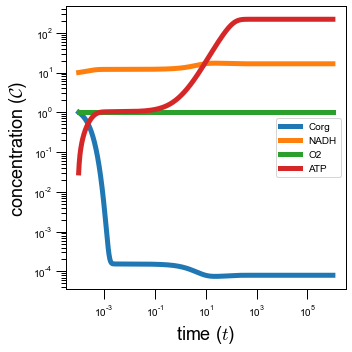

In [33]:
fig, ax = plt.subplots( 1, 1, figsize=(5, 5) )

ax.set_ylabel( 'concentration (' + r'$\mathcal{C}$)')
ax.set_xlabel( 'time (' + r'$t$)')
for idx in range(NUM_METS):
    ax.plot( t[:len(y_sol[idx])], y_sol[idx], lw=5 )
ax.legend([ 'Corg', 'NADH', 'O2', 'ATP' ], loc='best')
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
plt.show()

### Fluxes

In [34]:
def give_nus( y_sol, tpt ):
    x = y_sol[:, tpt].copy()
    Corg = x[0]
    NADH = x[1]
    O2 = x[2]
    ATP = x[3]

    NAD = r1 * NADH
    ADP = r2 * ATP

    nu_cat = Corg * (NAD ** 2) * phi_cat / gamma_cat
    nu_resp = (NADH ** 2) * O2 * phi_resp / gamma_resp
    nu_ana = Corg * (NADH ** S6) * (ATP ** S5) * phi_ana / gamma_ana
    
    return np.array([nu_cat, nu_resp, nu_ana])

In [35]:
nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

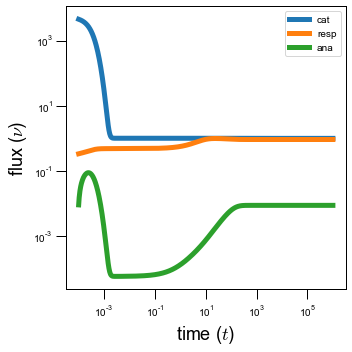

In [36]:
fig, ax = plt.subplots( 1, 1, figsize=(5, 5) )

ax.set_ylabel( 'flux (' + r'$\nu$)')
ax.set_xlabel( 'time (' + r'$t$)')
for idx in range(3):
    ax.plot( t[:len(nus[idx])], nus[idx], lw=5 )
ax.legend([ 'cat', 'resp', 'ana' ], loc='best')
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
plt.show()

# Sweeping over $\phi_{ana}$

In [37]:
mus = []
phianas = []

phi_cat = 0.4
phi_resp = 0.05

for t_phi_ana in np.linspace(0.01, 1-phi_cat-phi_resp):
    phi_ana = t_phi_ana.copy()

    y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
    NUM_METS = len(y0)

    # Evaluation time
    TFINAL = 1e6
    t = np.logspace(-4, 6, 1000 )
    S6 = 1.

    y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y


    nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

    mus.append(nus[-1, -1])
    phianas.append(t_phi_ana)

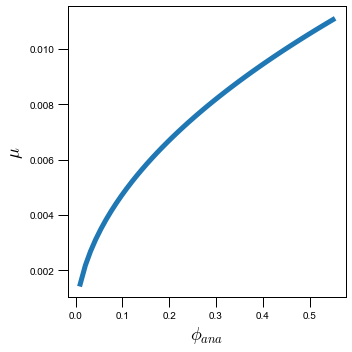

In [38]:
fig, ax = plt.subplots( 1, 1, figsize=(5, 5) )

ax.set_ylabel( r'$\mu$' )
ax.set_xlabel( r'$\phi_{ana}$' )
ax.plot( phianas, mus, lw=5 )
# ax.set_yscale('log')
# ax.set_xscale('log')

fig.tight_layout()
plt.show()

# Sweeping over $S_6$

In [41]:
mus = []
zcs = []

phi_ana = 1-phi_cat-phi_resp

for S6 in np.linspace(1., 6., 100):

    y0 = np.array([ Corg0, NADH0, O20, ATP0 ])
    NUM_METS = len(y0)

    # Evaluation time
    TFINAL = 1e6
    t = np.logspace(-4, 6, 1000 )

    y_sol = solve_ivp(het_model, [ 1e-4, TFINAL ],  y0, t_eval=t, method='Radau' ).y


    nus = np.array([give_nus(y_sol, tpt) for tpt in range(len(t))]).T

    mus.append(nus[-1, -1])
    zcs.append(S6)

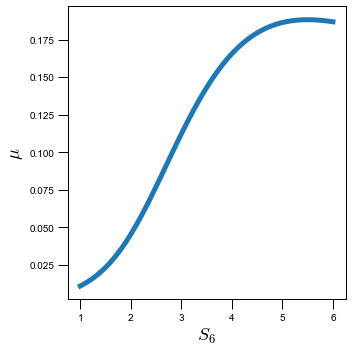

In [42]:
fig, ax = plt.subplots( 1, 1, figsize=(5, 5) )

ax.set_ylabel( r'$\mu$' )
ax.set_xlabel( r'$S_6$' )
ax.plot( zcs, mus, lw=5 )
# ax.set_yscale('log')
# ax.set_xscale('log')
s
fig.tight_layout()
plt.show()